# Using FastAI for Multi-class classification
> This is an example of the benefits of using FastAI for tackling classification problems.

- toc: true
- badges: true
- hide_binder_badge: true
- hide_deepnote_badge: true
- comments: true
- categories: [FastAI, jupyter, Classification, timm]
- image: images/space_image01.png

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai, timm
from fastai.vision.all import *
from itertools import compress

In [3]:
path = Path('/mnt/d/ML work/Hackaton')
path.is_dir()

True

In [4]:
fastai.__version__, torch.__version__, torch.cuda.is_available()

('2.7.9', '1.12.0', True)

## Create Pandas DataFrame

We create a Pandas DataFrame that summarizes all the files used for the hackaton.

In [5]:
train = (path/'train').ls()
valid = (path/'val').ls()
train_sample = random.sample(train, 200)
valid_sample = random.sample(valid, 100)
len(train_sample), len(valid_sample)

(200, 100)

### We start with a small sample of files to create extraction functions

In [6]:
train_sample[:10]

[Path('/mnt/d/ML work/Hackaton/train/B005_OD_104_0-0-0-0-0-0-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/A055_OD_51_0-1-0-0-0-0-1-0-1.png'),
 Path('/mnt/d/ML work/Hackaton/train/A067_OS_94_0-0-0-0-0-0-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/A097_OS_30_0-0-0-0-1-0-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/C075_OS_31_0-0-0-0-1-0-1-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/B082_OS_66_0-0-0-0-0-0-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/C038_OD_24_0-0-0-0-0-1-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/C114_OS_46_0-0-1-0-0-0-0-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/B067_OS_121_0-1-0-0-0-0-1-0-0.png'),
 Path('/mnt/d/ML work/Hackaton/train/A014_OD_80_0-0-0-0-1-0-1-0-1.png')]

In [7]:
cols = ['PatientID', 'Left/Right eye', 'B-Scan ID', 'Labels']
categories = ['Ungradable', 'Intraretinal_Fluid', 'Disturbance_VRI', 'Subretinal_Fluid', 'RPE_Elevation', 'Disruption_Inner_Retinal_Layers', 'Ellipsoid_Zone_Disruption', 'Other_Abnormality', 'RPE_Atrophy']
categories

['Ungradable',
 'Intraretinal_Fluid',
 'Disturbance_VRI',
 'Subretinal_Fluid',
 'RPE_Elevation',
 'Disruption_Inner_Retinal_Layers',
 'Ellipsoid_Zone_Disruption',
 'Other_Abnormality',
 'RPE_Atrophy']

In [8]:
n = valid_sample[5]

def path_to_dict(n):
    info = n.split('_')
    oh_values = [float(i) for i in info[-1].split('-')]
    bool_lab = [bool(i) for i in oh_values]
    labels = list(compress(categories, bool_lab))
    label_str = ['None'] if not labels else [' '.join(labels)]
    isNone = [1.0] if not labels else [0.0]

    return dict(zip(cols+categories+['isNone'], info[:3]+label_str+oh_values+isNone))

def final_dict(n):
    n_dict = path_to_dict(n.stem)
    n_dict['Path'] = n
    n_dict['Valid'] = True if n.parent.name == 'val' else False
    return n_dict

df_row = final_dict(n)
df_row

{'PatientID': 'B036',
 'Left/Right eye': 'OS',
 'B-Scan ID': '58',
 'Labels': 'None',
 'Ungradable': 0.0,
 'Intraretinal_Fluid': 0.0,
 'Disturbance_VRI': 0.0,
 'Subretinal_Fluid': 0.0,
 'RPE_Elevation': 0.0,
 'Disruption_Inner_Retinal_Layers': 0.0,
 'Ellipsoid_Zone_Disruption': 0.0,
 'Other_Abnormality': 0.0,
 'RPE_Atrophy': 0.0,
 'isNone': 1.0,
 'Path': Path('/mnt/d/ML work/Hackaton/val/B036_OS_58_0-0-0-0-0-0-0-0-0.png'),
 'Valid': True}

We can combine lists quickly to create the dictionaries that feed a row in a pandas dataframe.

In [9]:
aux = ['a', 'b', 'c', 'd']
nums = ['1', '2', '3', '4']
comb = dict(zip(nums, aux[:3] + ['e']))
comb

{'1': 'a', '2': 'b', '3': 'c', '4': 'e'}

In [10]:
a = ['']
not a[0]

True

In [11]:
df_data = pd.DataFrame([final_dict(n) for n in train_sample+valid_sample])
df_data.head()

,PatientID,Left/Right eye,B-Scan ID,Labels,Ungradable,Intraretinal_Fluid,Disturbance_VRI,Subretinal_Fluid,RPE_Elevation,Disruption_Inner_Retinal_Layers,Ellipsoid_Zone_Disruption,Other_Abnormality,RPE_Atrophy,isNone,Path,Valid
0,B005,OD,104,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/B005_OD_104_0-0-0-0-0-0-0-0-0.png,False
1,A055,OD,51,Intraretinal_Fluid Ellipsoid_Zone_Disruption RPE_Atrophy,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,/mnt/d/ML work/Hackaton/train/A055_OD_51_0-1-0-0-0-0-1-0-1.png,False
2,A067,OS,94,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/A067_OS_94_0-0-0-0-0-0-0-0-0.png,False
3,A097,OS,30,RPE_Elevation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A097_OS_30_0-0-0-0-1-0-0-0-0.png,False
4,C075,OS,31,RPE_Elevation Ellipsoid_Zone_Disruption,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/C075_OS_31_0-0-0-0-1-0-1-0-0.png,False


In [12]:
len(df_data[df_data.isNone==1.0])

185

<AxesSubplot:>

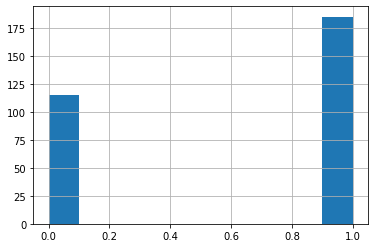

In [13]:
df_data['Empty'] = 0
df_data.loc[df_data.isNone==1, 'Empty'] = 1
df_data['Empty'].hist()

### Now let's do this to the entire dataset

In [14]:
data = get_image_files(path, folders=['train', 'val'])
data

(#68992) [Path('/mnt/d/ML work/Hackaton/train/A001_OD_0_0-0-0-0-0-0-0-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_100_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_101_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_102_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_103_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_104_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_105_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_106_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_107_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_108_0-0-0-1-0-0-1-0-0.png')...]

In [15]:
full_data_df = pd.DataFrame([final_dict(n) for n in data])
full_data_df.head()

,PatientID,Left/Right eye,B-Scan ID,Labels,Ungradable,Intraretinal_Fluid,Disturbance_VRI,Subretinal_Fluid,RPE_Elevation,Disruption_Inner_Retinal_Layers,Ellipsoid_Zone_Disruption,Other_Abnormality,RPE_Atrophy,isNone,Path,Valid
0,A001,OD,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/A001_OD_0_0-0-0-0-0-0-0-0-0.png,False
1,A001,OD,100,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_100_0-0-0-1-0-0-1-0-0.png,False
2,A001,OD,101,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_101_0-0-0-1-0-0-1-0-0.png,False
3,A001,OD,102,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_102_0-0-0-1-0-0-1-0-0.png,False
4,A001,OD,103,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_103_0-0-0-1-0-0-1-0-0.png,False


<AxesSubplot:>

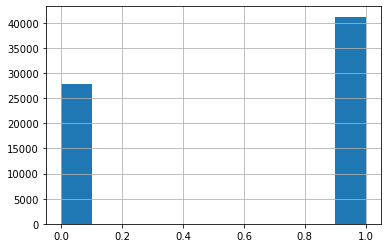

In [16]:
full_data_df.isNone.hist()

In [17]:
full_data_df.to_pickle(path/'DataList2.pkl')

### From now on we can just reload the saved pickle file.

In [6]:
full_data_df = pd.read_pickle(path/'DataList2.pkl')
full_data_df.head()

,PatientID,Left/Right eye,B-Scan ID,Labels,Ungradable,Intraretinal_Fluid,Disturbance_VRI,Subretinal_Fluid,RPE_Elevation,Disruption_Inner_Retinal_Layers,Ellipsoid_Zone_Disruption,Other_Abnormality,RPE_Atrophy,isNone,Path,Valid
0,A001,OD,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/A001_OD_0_0-0-0-0-0-0-0-0-0.png,False
1,A001,OD,100,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_100_0-0-0-1-0-0-1-0-0.png,False
2,A001,OD,101,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_101_0-0-0-1-0-0-1-0-0.png,False
3,A001,OD,102,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_102_0-0-0-1-0-0-1-0-0.png,False
4,A001,OD,103,Subretinal_Fluid Ellipsoid_Zone_Disruption,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A001_OD_103_0-0-0-1-0-0-1-0-0.png,False


In [7]:
full_data_df[full_data_df['Valid']].head()

,PatientID,Left/Right eye,B-Scan ID,Labels,Ungradable,Intraretinal_Fluid,Disturbance_VRI,Subretinal_Fluid,RPE_Elevation,Disruption_Inner_Retinal_Layers,Ellipsoid_Zone_Disruption,Other_Abnormality,RPE_Atrophy,isNone,Path,Valid
61184,A006,OS,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/val/A006_OS_0_0-0-0-0-0-0-0-0-0.png,True
61185,A006,OS,100,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/val/A006_OS_100_0-0-0-0-0-0-0-0-0.png,True
61186,A006,OS,101,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/val/A006_OS_101_0-0-0-0-0-0-0-0-0.png,True
61187,A006,OS,102,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/val/A006_OS_102_0-0-0-0-0-0-0-0-0.png,True
61188,A006,OS,103,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/val/A006_OS_103_0-0-0-0-0-0-0-0-0.png,True


## Create the model

### Figure out the data shape for all the images.

In [81]:
train[:10]

(#10) [Path('/mnt/d/ML work/Hackaton/train/A001_OD_0_0-0-0-0-0-0-0-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_100_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_101_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_102_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_103_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_104_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_105_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_106_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_107_0-0-0-1-0-0-1-0-0.png'),Path('/mnt/d/ML work/Hackaton/train/A001_OD_108_0-0-0-1-0-0-1-0-0.png')]

(512, 1024)


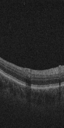

In [20]:
img = PILImageBW.create(train[0])
print(img.size)
img.to_thumb(128)

In [21]:
from fastcore.parallel import *

def f(o): return PILImageBW.create(o).size
sizes = parallel(f, train, n_workers=8)
pd.Series(sizes).value_counts()

KeyboardInterrupt: 

In [ ]:
sizes = parallel(f, valid, n_workers=8)
pd.Series(sizes).value_counts()

### Create a data loader

In [8]:
def sample_df(df, pct=0.01):
    total_imgs = len(df)
    idx_sample = random.sample(range(total_imgs), int(total_imgs*pct))
    small_df = df.iloc[idx_sample].copy()
    cols = small_df.columns
    small_df.reset_index(inplace=True)
    return small_df[cols] 

In [9]:
small_df = sample_df(full_data_df)
small_df.head()

,PatientID,Left/Right eye,B-Scan ID,Labels,Ungradable,Intraretinal_Fluid,Disturbance_VRI,Subretinal_Fluid,RPE_Elevation,Disruption_Inner_Retinal_Layers,Ellipsoid_Zone_Disruption,Other_Abnormality,RPE_Atrophy,isNone,Path,Valid
0,A122,OS,39,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/A122_OS_39_0-0-0-0-0-0-0-0-0.png,False
1,A096,OD,97,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/A096_OD_97_0-0-0-0-0-0-0-0-0.png,False
2,A198,OS,117,Intraretinal_Fluid Ellipsoid_Zone_Disruption,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/A198_OS_117_0-1-0-0-0-0-1-0-0.png,False
3,B094,OD,67,RPE_Elevation Ellipsoid_Zone_Disruption,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,/mnt/d/ML work/Hackaton/train/B094_OD_67_0-0-0-0-1-0-1-0-0.png,False
4,C089,OD,22,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/mnt/d/ML work/Hackaton/train/C089_OD_22_0-0-0-0-0-0-0-0-0.png,False


In [10]:
def get_x(n): return n['Path']
def get_y(n): return n['Labels'].split(' ')

def splitter(df):
    train = df.index[~df['Valid']].to_list() # This splitter uses the entire train folder for training
    valid = df.index[df['Valid']].to_list()  # This splitter uses the validation folder for validation
    return train, valid

In [11]:
t, v = splitter(small_df)
len(t), len(v), t[:10], v[:10]

(611,
 78,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [18, 22, 28, 34, 49, 50, 52, 54, 66, 87])

In [12]:
size = 128
item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection)

dblock = DataBlock(
        blocks=(ImageBlock(PILImageBW), MultiCategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=splitter, # RandomSplitter(valid_pct=0.2),
        item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75),)

In [13]:
dsets = dblock.datasets(small_df)
dsets.train[0]

(PILImageBW mode=L size=512x1024,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0.]))

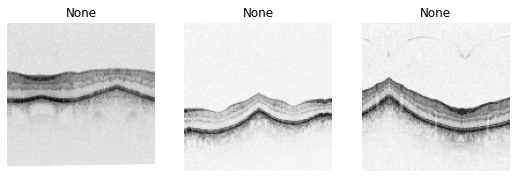

In [14]:
dls = dblock.dataloaders(small_df, bs=32)
dls.show_batch(nrows=1, ncols=3)

In [15]:
arch = 'convnext_small_in22k'
f1sc = F1ScoreMulti()

In [16]:
def train(arch, size, item=item, accum=1, finetune=True, epochs=5, metrics=partial(accuracy_multi, thres=0.2)):
    dblock = DataBlock(
        blocks=(ImageBlock(PILImageBW), MultiCategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=splitter, # RandomSplitter(valid_pct=0.2),
        item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75),)
    
    dls = dblock.dataloaders(full_data_df, bs=128//accum)
    cbs = GradientAccumulation(128) if accum else []
    learn = vision_learner(dls, arch, metrics=metrics, cbs=cbs).to_fp16()
    #result = learn.lr_find()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(), learn
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
        return learn

In [50]:
val_tta, learn = train(arch, 128, epochs=15, accum=1, finetune=True, metrics=f1sc)

epoch,train_loss,valid_loss,f1_score,time
0,0.130614,0.166365,0.556027,10:27


epoch,train_loss,valid_loss,f1_score,time
0,0.084366,0.117138,0.648208,17:18
1,0.069443,0.116196,0.720429,17:19
2,0.063303,0.113052,0.698306,17:19
3,0.056162,0.113664,0.720716,17:20
4,0.050137,0.122819,0.701130,17:18
5,0.044736,0.124415,0.707268,17:18
6,0.041143,0.120144,0.707138,17:19
7,0.037087,0.116998,0.718447,17:19
8,0.033376,0.120445,0.726524,17:18
9,0.029777,0.122809,0.728514,17:20


In [56]:
val_tta[0].shape

torch.Size([7808, 10])

In [57]:
learn.dls.vocab

['Disruption_Inner_Retinal_Layers', 'Disturbance_VRI', 'Ellipsoid_Zone_Disruption', 'Intraretinal_Fluid', 'None', 'Other_Abnormality', 'RPE_Atrophy', 'RPE_Elevation', 'Subretinal_Fluid', 'Ungradable']

In [69]:
learn.export(path/'20220815_ConvNext_128px_01.pkl')

In [17]:
learn = load_learner(path/'20220815_ConvNext_128px_01.pkl')

In [18]:
item = Resize(512, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection)
size = 256

dblock = DataBlock(
        blocks=(ImageBlock(PILImageBW), MultiCategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=splitter, # RandomSplitter(valid_pct=0.2),
        item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75),)

def refine_train(arch, size, learner=None, item=item, accum=1, finetune=True, epochs=5, metrics=partial(accuracy_multi, thres=0.2)):
    dls = dblock.dataloaders(full_data_df, bs=128//accum)
    cbs = GradientAccumulation(128) if accum else []
    learn = ifnone(learner, vision_learner(dls, arch, metrics=metrics, cbs=cbs).to_fp16())
    learn.dls = dls
    
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(), learn
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
        return _, learn

In [19]:
val_tta256, learn = refine_train(arch, 256, learner=learn, accum=2, metrics=f1sc)

epoch,train_loss,valid_loss,f1_score,time
0,0.036489,0.116934,0.741271,35:01


epoch,train_loss,valid_loss,f1_score,time
0,0.031806,0.121453,0.759434,2:36:13
1,0.029942,0.116507,0.736693,2:36:03
2,0.022814,0.123035,0.747249,2:35:57
3,0.017617,0.134090,0.736593,2:35:57
4,0.013542,0.129386,0.748571,2:35:58


In [20]:
learn.export(path/'20220817_ConvNext_256px_01.pkl')

In [50]:
valid_data = learn.dls.valid

In [51]:
preds, targs = learn.get_preds(dl = valid_data)

In [59]:
preds = tensor(preds>0.5)
preds, targs

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [60]:
f1sc(preds, targs)

0.7485708693055197

In [61]:
tta_preds,_ = learn.tta(dl=valid_data)

In [63]:
tta_preds = tensor(tta_preds>0.5)

In [64]:
f1sc(tta_preds, targs)

0.750392806526196

In [66]:
PILBase??

Init signature: PILBase()
Docstring:     
This class represents an image object.  To create
:py:class:`~PIL.Image.Image` objects, use the appropriate factory
functions.  There's hardly ever any reason to call the Image constructor
directly.

* :py:func:`~PIL.Image.open`
* :py:func:`~PIL.Image.new`
* :py:func:`~PIL.Image.frombytes`
Source:        
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn:Path|str|Tensor|ndarray|bytes, **kwargs)->None:
        "Open an `Image` from path `fn`"
        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn, TensorMask): fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **merge(cls._open_args

### Check data empty spot

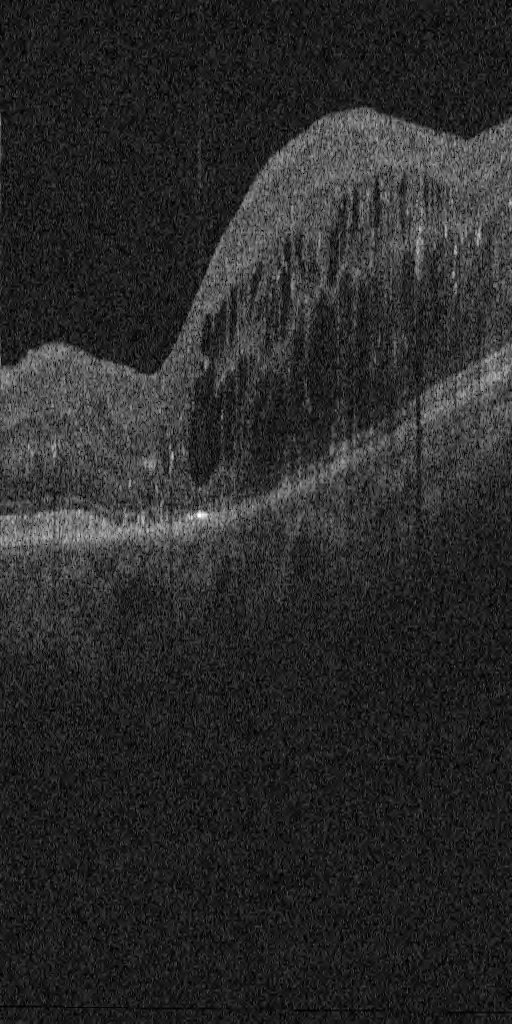

In [16]:
file_list = small_df['Path'].to_list()
img = Image.open(file_list[0]).convert('L')
img